## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
import torch
from torch import ones, zeros, eye

from sbi.inference import SNLE, SNPE
from sbi.utils import BoxUniform
from sbi.utils.torchutils import atleast_2d
from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior, RejectionPosterior, VIPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

from copy import deepcopy

import matplotlib.pyplot as plt

from loss_calibration.loss import StepLoss_weighted, SigmoidLoss_weighted
import loss_calibration.toy_example as toy

Prior and Simulator

In [5]:
prior =BoxUniform([0], [5])
def sim(theta):
    return theta + torch.randn(theta.shape) * 0.2

Define a potential

In [6]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device=device)
    
    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            return torch.log(acquisition_fn(theta))


Define a cost function and an acquisition function

In [7]:
#cost_fn = StepLoss_weighted([2,1], 0.)    # ! torch.gt breaks backward pass of gradients
cost_fn = SigmoidLoss_weighted([2,1], 0.)
threshold = 2.0
threshold_dim = 0

In [8]:
num_monte_carlo_samples_likelihood = 20
num_monte_carlo_samples_posterior = 1

In [9]:
def acquisition_fn(theta_0):
    theta_0 = atleast_2d(theta_0)
    # 1.sample from likelihood
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) 
    predicted_theta_given_x = []
    # 2. for each sampled x, sample from the posterior
    for px in predicted_x.swapaxes(0,1):
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px))
    predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) 
    # 3. calculate associated cost
    predicted_decision = (predicted_theta_given_x > threshold).float()
    estimated_cost = cost_fn(theta_0[:,threshold_dim].unsqueeze(1).repeat(1,num_monte_carlo_samples_likelihood), predicted_decision[:,:,threshold_dim])
    return estimated_cost.mean(dim=1)

In [11]:
n_rounds = 10
proposal = prior

# inference objects
inference_likelihood = SNLE(prior)
inference_posterior = SNPE(prior)

proposals = []
likelihood_estimators = []
posterior_estimators = []

for r in range(n_rounds): # rounds
    print(f'\n----- ROUND {r} -----')
    theta = proposal.sample((1000,))
    x = sim(theta)
    # train both SNLE and SNPE
    likelihood_estimator = inference_likelihood.append_simulations(theta, x).train(max_num_epochs=100)
    print('\n')
    posterior_estimator = inference_posterior.append_simulations(theta, x, proposal=proposal).train(max_num_epochs=100)

    potential = AcquisitionPotential(prior, x_o=zeros(1, 2), device="cpu")
    #prior_tf = mcmc_transform(prior)
    #acquisition_sampler = VIPosterior(potential_fn=potential, prior=prior, q='maf', theta_transform= mcmc_transform(prior), vi_method='fKL').train()
    #acquisition_sampler = MCMCPosterior(potential_fn=potential, theta_transform=prior_tf, proposal=prior, init_strategy="proposal", method="slice_np_vectorized", num_chains=100)
    acquisition_sampler = RejectionPosterior(potential_fn=potential, proposal=prior)
    proposal = acquisition_sampler

    likelihood_estimators.append(deepcopy(likelihood_estimator))
    posterior_estimators.append(deepcopy(posterior_estimator))
    proposals.append(deepcopy(proposal))
    torch.save(theta, f"./results/toy_example/active_learning/simple_round{r}_sampled_theta.pt")
    torch.save(proposal, f"./results/toy_example/active_learning/simple_round{r}_proposal.pt")
    torch.save(likelihood_estimator, f"./results/toy_example/active_learning/simple_round{r}_likelihood_estimator.pt")
    torch.save(posterior_estimator, f"./results/toy_example/active_learning/simple_round{r}_posterior_estimator.pt")


----- ROUND 0 -----
 Neural network successfully converged after 72 epochs.

 Neural network successfully converged after 39 epochs.
----- ROUND 1 -----


Drawing 1000 posterior samples: 1326it [00:06, 189.81it/s]                         


 Neural network successfully converged after 22 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
----- ROUND 2 -----


Drawing 1000 posterior samples: 1339it [00:02, 464.07it/s]                         


 Neural network successfully converged after 42 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
----- ROUND 3 -----


Drawing 1000 posterior samples: 1269it [00:03, 415.10it/s]                         


 Neural network successfully converged after 26 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
----- ROUND 4 -----


Drawing 1000 posterior samples: 1372it [00:05, 262.77it/s]                         


 Neural network successfully converged after 43 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
----- ROUND 5 -----


Drawing 1000 posterior samples: 1303it [00:12, 104.65it/s]                         


 Neural network successfully converged after 27 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.
----- ROUND 6 -----


Drawing 1000 posterior samples: 1400it [00:04, 299.26it/s]                         


 Neural network successfully converged after 24 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.
----- ROUND 7 -----


Drawing 1000 posterior samples: 1420it [00:06, 222.31it/s]                         


 Training neural network. Epochs trained: 8

In [ ]:
n_samples_proposal = 1000
samples_proposal = proposal.sample((n_samples_proposal,))
samples_prior = prior.sample((10,))

Drawing 1000 posterior samples: 1216it [00:03, 327.96it/s]                         


In [ ]:
torch.save(samples_proposal, f"./results/toy_example/active_learning/simple_round{r+1}_sampled_theta.pt")

In [ ]:
thetas_linspace = torch.linspace(0,5,1000).unsqueeze(1)
n_potentials = 50
potential_thetas_linspace = torch.stack([potential(thetas_linspace) for _ in range(n_potentials)])
# potential_thetas_linspace = torch.cat([torch.stack([potential(th) for th in thetas_linspace], dim=1) for r in range(n_potential)])

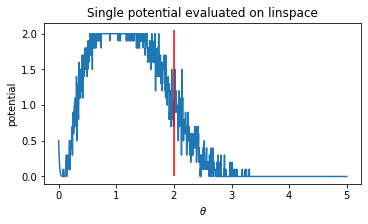

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.numpy(), potential_thetas_linspace[0].exp().numpy())
ax.vlines(threshold, ymin=0.0, ymax=max(potential_thetas_linspace[0].exp())+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title("Single potential evaluated on linspace")
fig.savefig("./results/toy_example/active_learning/single_potential.pdf")

Text(0.5, 0, '$\\theta$')

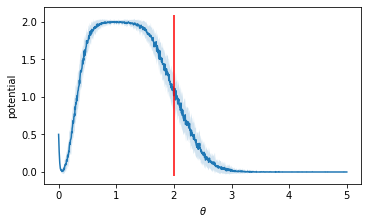

In [ ]:
mean_potential = potential_thetas_linspace.exp().mean(dim=0)
std_potential = potential_thetas_linspace.exp().std(dim=0)

fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.squeeze(), mean_potential)
ax.fill_between(thetas_linspace.squeeze().numpy(), (mean_potential-std_potential).numpy(), (mean_potential+std_potential).numpy(), alpha=0.2)
ax.vlines(threshold, ymin=-0.05, ymax=max(mean_potential+std_potential)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
#ax.set_title(f"Mean and std over {n_potential} potentials evaluated on linspace")
#fig.savefig("./results/active_learning/toy_example_potential.pdf")

In [ ]:
potentials_samples_proposal = potential(samples_proposal).exp()

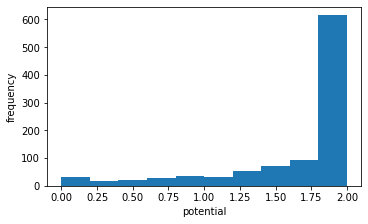

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(potentials_samples_proposal.numpy())
ax.set_xlabel('potential')
ax.set_ylabel('frequency')
#ax.set_title(f"Histogram over potentials of {n_samples_proposal} samples from the proposal")
#fig.savefig("./results/active_learning/toy_example_potential_histogram.pdf")
plt.show()


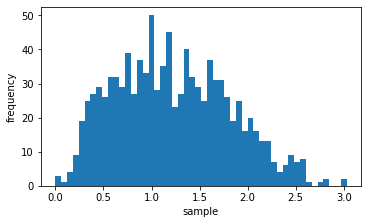

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(torch.round(samples_proposal, decimals=2).numpy(), bins=50)
ax.set_xlabel('sample')
ax.set_ylabel('frequency')
#ax.set_title(f"Histogram over {n_samples_proposal} samples from the proposal")
#fig.savefig("./results/active_learning/toy_example_potential_samples_proposal.pdf")
plt.show()

Text(0, 0.5, 'potential')

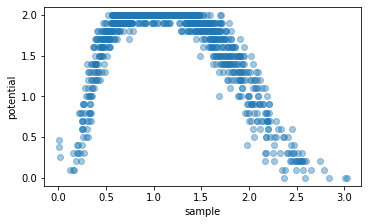

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.scatter(samples_proposal, potentials_samples_proposal, alpha=0.4)
ax.set_xlabel('sample')
ax.set_ylabel('potential')